In [ ]:
import zipfile

# Extract the dataset
with zipfile.ZipFile('/content/dataset_aug1.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_aug1')

# Set input and mask directories
input_dir = 'dataset_aug1/input'
mask_dir = 'dataset_aug1/output'

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models.segmentation as segmentation
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
class DentalXraySegmentationDataset(Dataset):
    def __init__(self, input_dir, mask_dir):
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_paths[idx]).convert('RGB')
        mask_img = Image.open(self.mask_paths[idx]).convert('L')

        # Resize and normalize
        input_tensor = TF.to_tensor(input_img)
        input_tensor = TF.normalize(input_tensor, mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225])
        mask_tensor = TF.to_tensor(mask_img)
        mask_tensor = (mask_tensor > 0.5).float()

        return input_tensor, mask_tensor

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)
        smooth = 1e-5
        intersection = (inputs * targets).sum(dim=(1,2,3))
        dice = (2 * intersection + smooth) / (inputs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + smooth)
        dice_loss = 1 - dice.mean()
        return bce + dice_loss

In [ ]:
# Load and split the dataset
full_dataset = DentalXraySegmentationDataset(input_dir, mask_dir)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Loaders
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# DeepLabV3 with ResNet50
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 171MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use g

In [ ]:
num_epochs = 30
losses, accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == masks).float().sum().item()
        total += torch.numel(preds)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    scheduler.step(epoch_loss)

Epoch [1/30], Loss: 1.1456, Accuracy: 0.9681
Epoch [2/30], Loss: 0.8112, Accuracy: 0.9834
Epoch [3/30], Loss: 0.6191, Accuracy: 0.9871
Epoch [4/30], Loss: 0.4923, Accuracy: 0.9897
Epoch [5/30], Loss: 0.4243, Accuracy: 0.9912
Epoch [6/30], Loss: 0.3774, Accuracy: 0.9922
Epoch [7/30], Loss: 0.3398, Accuracy: 0.9930
Epoch [8/30], Loss: 0.3047, Accuracy: 0.9937
Epoch [9/30], Loss: 0.2881, Accuracy: 0.9940
Epoch [10/30], Loss: 0.2693, Accuracy: 0.9944
Epoch [11/30], Loss: 0.2519, Accuracy: 0.9949
Epoch [12/30], Loss: 0.2352, Accuracy: 0.9952
Epoch [13/30], Loss: 0.2264, Accuracy: 0.9954
Epoch [14/30], Loss: 0.2227, Accuracy: 0.9955
Epoch [15/30], Loss: 0.2190, Accuracy: 0.9955
Epoch [16/30], Loss: 0.2283, Accuracy: 0.9952
Epoch [17/30], Loss: 0.2154, Accuracy: 0.9955
Epoch [18/30], Loss: 0.2033, Accuracy: 0.9959
Epoch [19/30], Loss: 0.1928, Accuracy: 0.9962
Epoch [20/30], Loss: 0.1884, Accuracy: 0.9963
Epoch [21/30], Loss: 0.1868, Accuracy: 0.9962
Epoch [22/30], Loss: 0.1844, Accuracy: 0.99

In [ ]:
def evaluate_metrics(model, dataloader):
    model.eval()
    dice_scores, iou_scores, accuracy_scores = [], [], []
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            preds = torch.sigmoid(outputs) > 0.5

            intersection = (preds * masks).sum(dim=(1,2,3))
            union = (preds + masks).sum(dim=(1,2,3))
            iou = (intersection + 1e-6) / (union - intersection + 1e-6)
            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            acc = ((preds == masks).float().mean(dim=(1,2,3)))

            dice_scores.extend(dice.cpu().numpy())
            iou_scores.extend(iou.cpu().numpy())
            accuracy_scores.extend(acc.cpu().numpy())

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(masks.view(-1).cpu().numpy())

    print("\n📊 Metrics on Test Set:")
    print(f"Dice Score: {np.mean(dice_scores):.4f}")
    print(f"IoU Score: {np.mean(iou_scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f}")

    cm = confusion_matrix(all_targets, all_preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"Sensitivity: {tp / (tp + fn):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}")

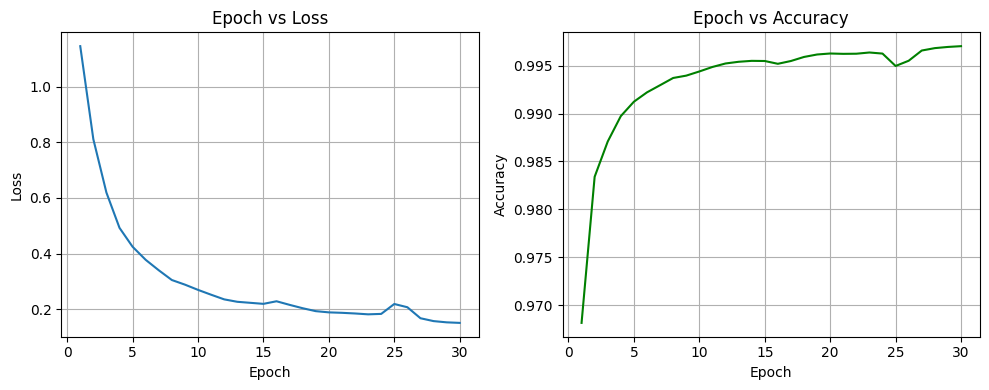

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)['out']
        preds = torch.sigmoid(outputs) > 0.5

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12, num_images * 3))
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, 3*i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        plt.imshow(np.clip(img, 0, 1))
        plt.title("Input")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(preds[i][0], cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


📊 Metrics on Test Set:
Dice Score: 0.7980
IoU Score: 0.6860
Accuracy: 0.9949
Sensitivity: 0.8670
Specificity: 0.9975


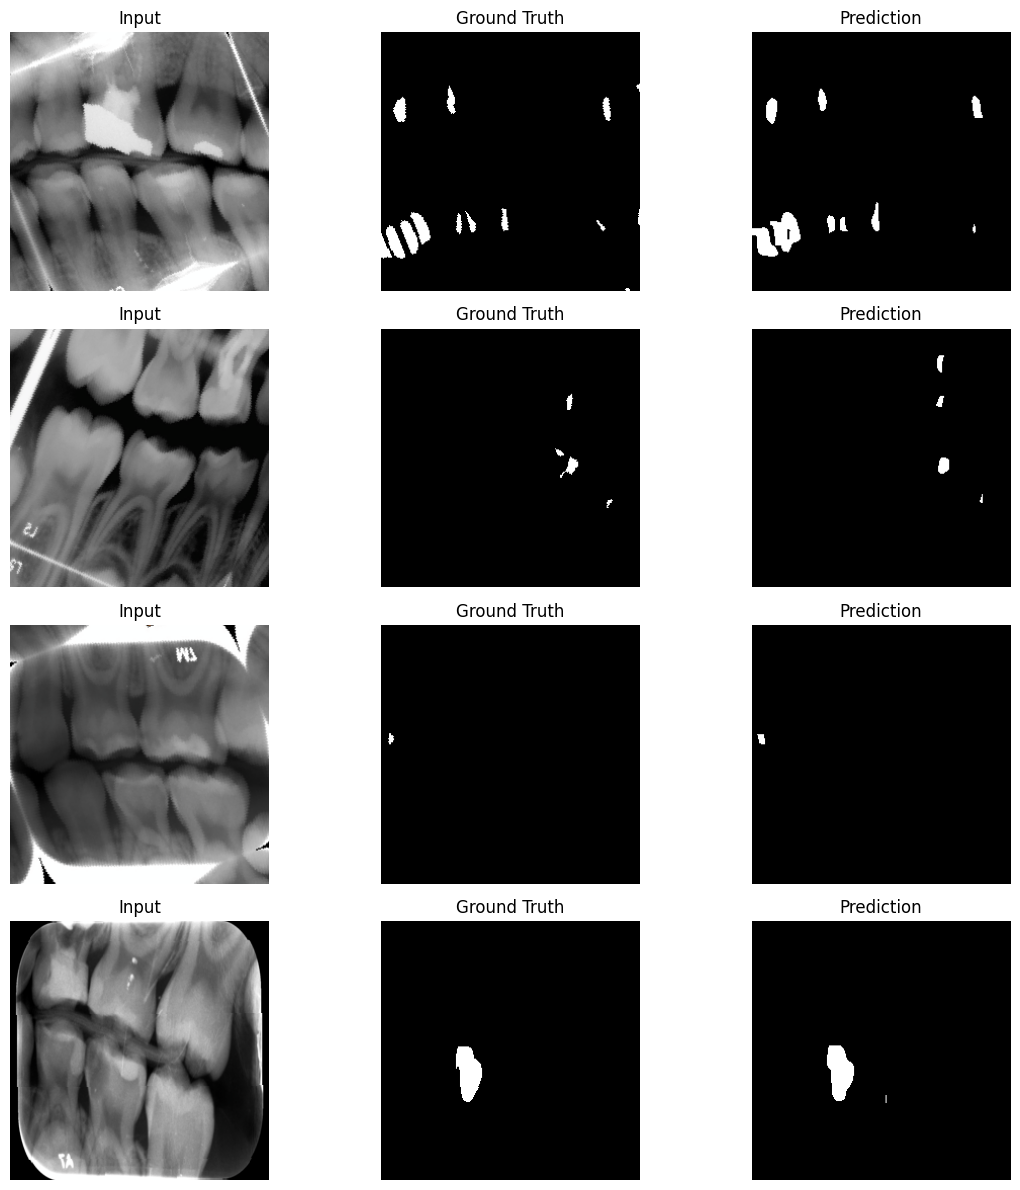

In [ ]:
# Evaluate and visualize
evaluate_metrics(model, test_loader)
visualize_predictions(model, test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrices(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            if isinstance(outputs, dict):  # for models like DeepLab
                outputs = outputs['out']
            preds = torch.sigmoid(outputs) > 0.5

            # Flatten and collect predictions
            all_preds.extend(preds.cpu().view(-1).numpy())
            all_targets.extend(masks.cpu().view(-1).numpy())

    # Convert to integer binary format
    all_preds = np.array(all_preds).astype(int)
    all_targets = np.array(all_targets).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds, labels=[0, 1])
    cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-6)

    # Print classification report
    print("\n📄 Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=["Non-Caries", "Caries"]))

    # Sensitivity (Recall for class 1) and Specificity (Recall for class 0)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)
    print(f"\n📊 Sensitivity: {sensitivity:.4f}")
    print(f"📊 Specificity: {specificity:.4f}")

    # Plot the matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Caries', 'Caries'], yticklabels=['Non-Caries', 'Caries'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Caries', 'Caries'], yticklabels=['Non-Caries', 'Caries'])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()


📄 Classification Report:
              precision    recall  f1-score   support

  Non-Caries       1.00      1.00      1.00  27758650
      Caries       0.87      0.87      0.87    552902

    accuracy                           0.99  28311552
   macro avg       0.93      0.93      0.93  28311552
weighted avg       0.99      0.99      0.99  28311552


📊 Sensitivity: 0.8670
📊 Specificity: 0.9975


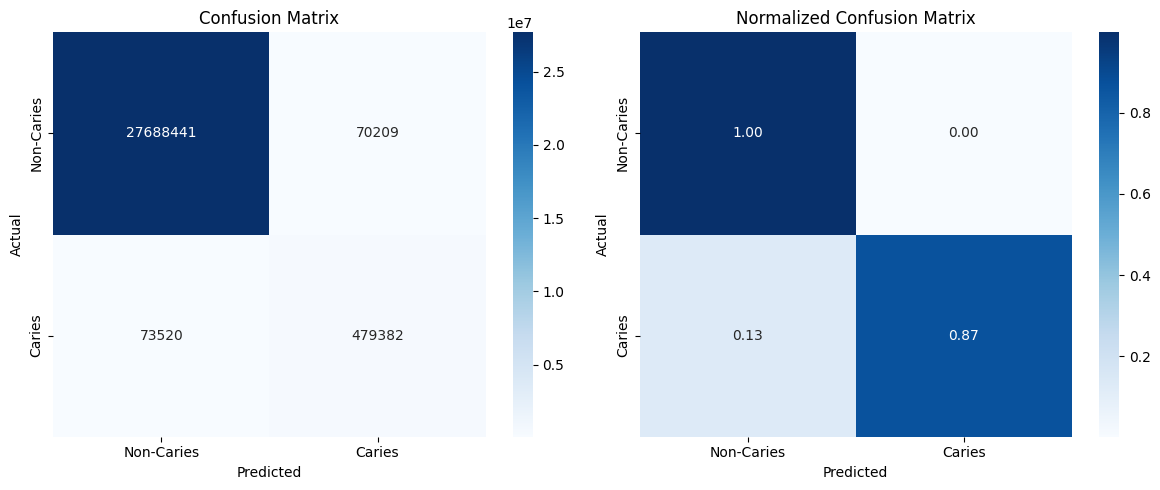

In [ ]:
plot_confusion_matrices(model, test_loader)